In [9]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os
PATH = r"C:\Users\aryan\OneDrive\Desktop\DA Projects\AIML\Project\creditcard_2023.csv"

# Load data
if os.path.exists(PATH):
    dff = pd.read_csv(PATH)
    print("Data loaded successfully.")
else:
    print("File not found.")

Data loaded successfully.


In [10]:
dff.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [11]:
# Checking null values

total = dff.isnull().sum().sort_values(ascending=False)
percent = (dff.isnull().sum()/dff.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose(

)# No missing data in teh dataset

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Checking data unbalance wrt target value(Class)
temp = dff["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Cyan"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')


In [ ]:
# Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable Class.

In [53]:
#Data Exploration

In [54]:
# Transactions in Time

In [57]:
class0 = dff.loc[dff['Class'] == 0]["Time"]
class1 = dff.loc[dff['Class'] == 1]["Time"]

hist_data = [class0,class1]
labels = ['Not fraud','Fraud']

import plotly.figure_factory as ff
fig = ff.create_distplot(hist_data,labels,show_hist=False,show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot',
                     xaxis = dict(title='Time[s]'))
iplot(fig,filename='dist_only')


In [59]:
#Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.
#Let's look into more details to the time distribution of both classes transaction, as well as to aggregated values of transaction count and amount, per hour. We assume (based on observation of the time distribution of transactions) that the time unit is second.

In [20]:
# Extract the hour from the 'Time' column
dff['Hour'] = dff['Time'].apply(lambda x: np.floor(x / 3600))

# Group the data by 'Hour' and 'Class'

tmp = dff.groupby(['Hour', 'Class'])['Amount'].agg(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()

# Create a new DataFrame with renamed columns
dft = pd.DataFrame(tmp)
dft.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
# Display the first few rows
dft.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


Text(0.5, 1.0, 'Fraud')

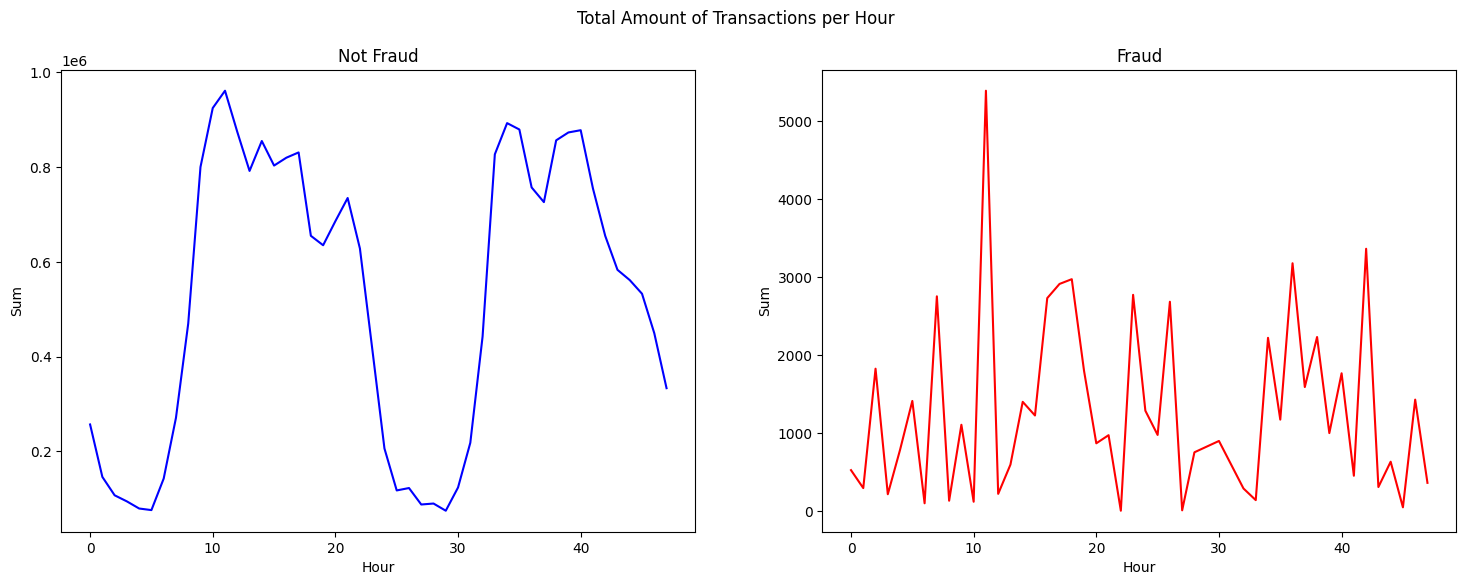

In [43]:
# Sum over time for both fraud and notfraud transactions
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(18,6))
s = sns.lineplot(ax=ax1,x="Hour",y="Sum",data = dft.loc[dft.Class == 0],color='blue')
s = sns.lineplot(ax=ax2,x="Hour",y="Sum",data = dft.loc[dft.Class == 1],color="red")
plt.suptitle("Total Amount of Transactions per Hour")
ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

Text(0.5, 1.0, 'Fraud')

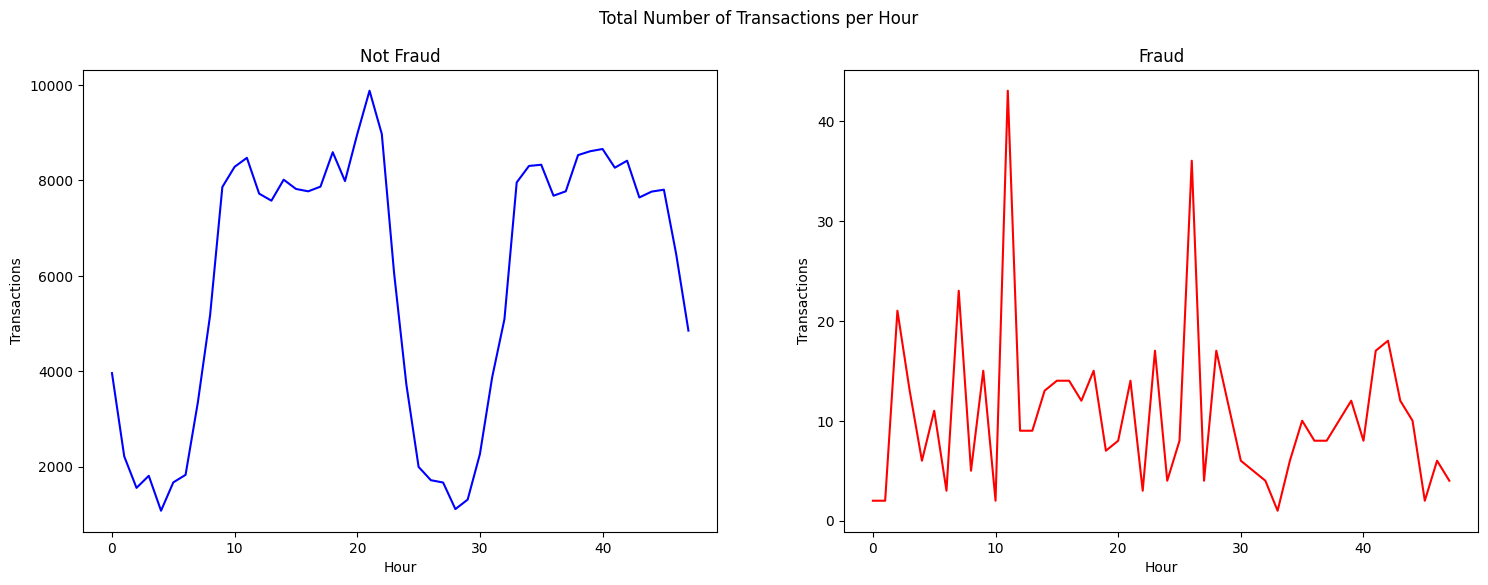

In [44]:
# Total transactions over time for both fraud and notfraud transactions
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(18,6))
s = sns.lineplot(ax=ax1,x="Hour",y="Transactions",data = dft.loc[dft.Class == 0],color='blue')
s = sns.lineplot(ax=ax2,x="Hour",y="Transactions",data = dft.loc[dft.Class == 1],color="red")
plt.suptitle("Total Number of Transactions per Hour")
ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

Text(0.5, 1.0, 'Fraud')

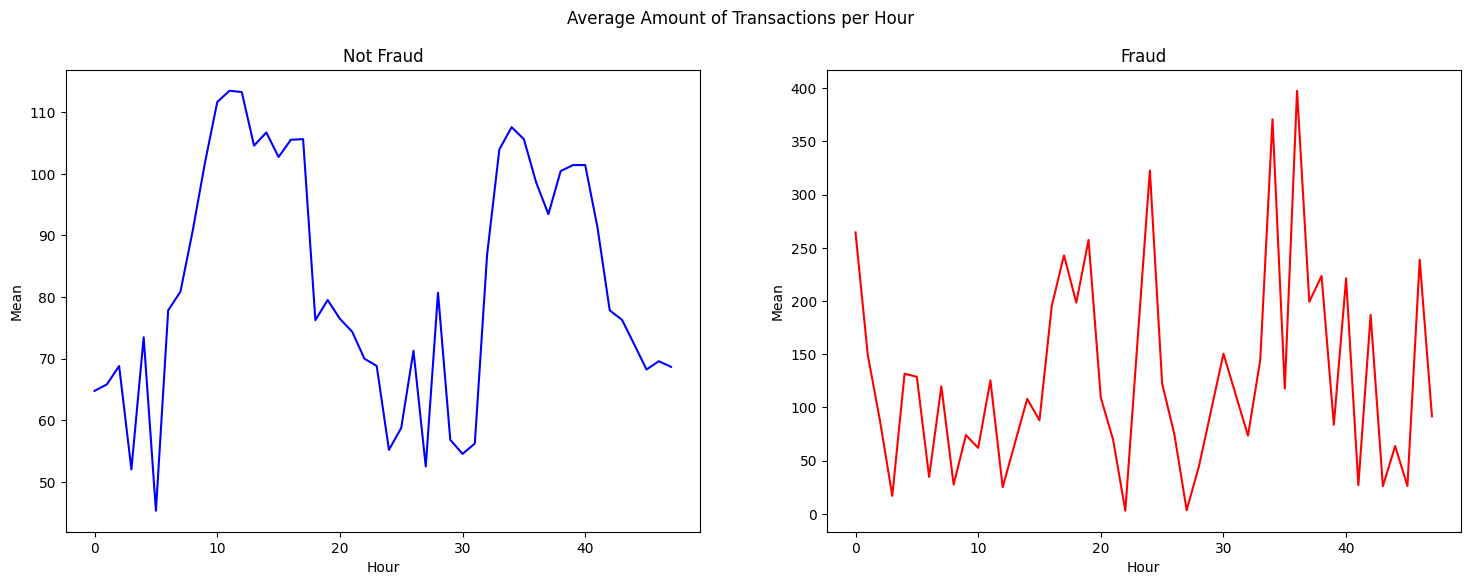

In [45]:
# AVG Transactions over time for both fraud and notfraud transactions
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(18,6))
s = sns.lineplot(ax=ax1,x="Hour",y="Mean",data = dft.loc[dft.Class == 0],color='blue')
s = sns.lineplot(ax=ax2,x="Hour",y="Mean",data = dft.loc[dft.Class == 1],color="red")
plt.suptitle("Average Amount of Transactions per Hour")
ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

Text(0.5, 1.0, 'Fraud')

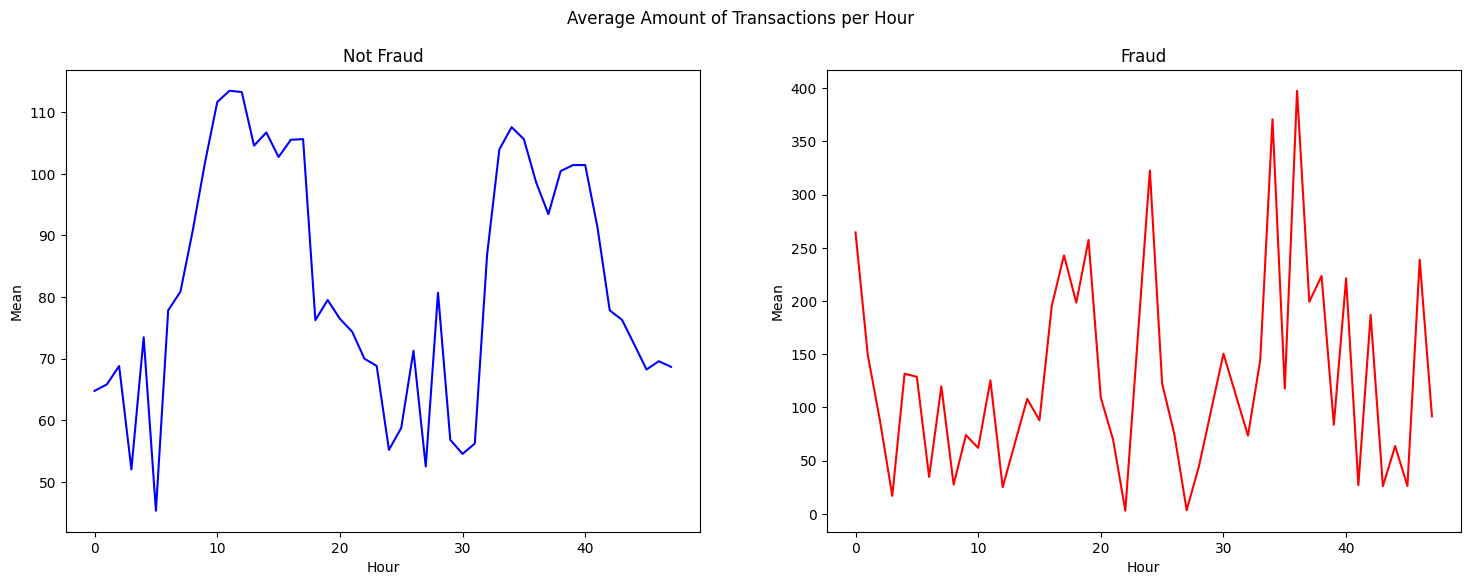

In [46]:
# AVG Transactions over time for both fraud and notfraud transactions
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(18,6))
s = sns.lineplot(ax=ax1,x="Hour",y="Mean",data = dft.loc[dft.Class == 0],color='blue')
s = sns.lineplot(ax=ax2,x="Hour",y="Mean",data = dft.loc[dft.Class == 1],color="red")
plt.suptitle("Average Amount of Transactions per Hour")
ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

Text(0.5, 1.0, 'Fraud')

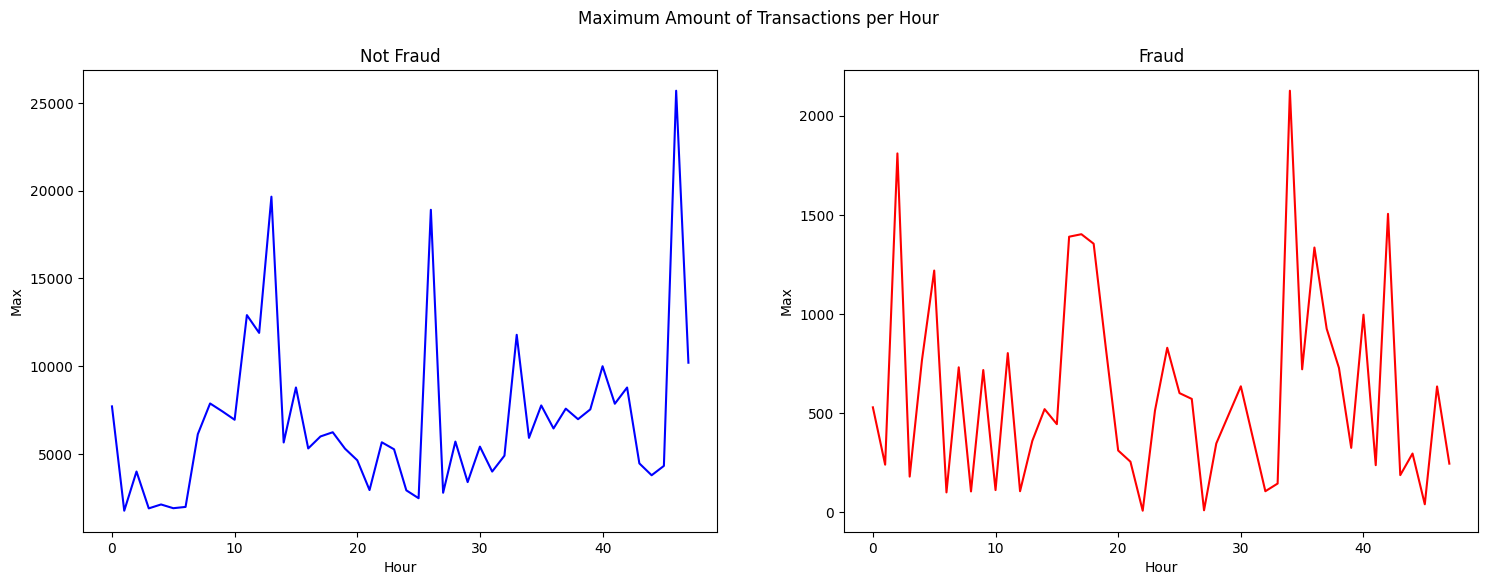

In [47]:
# Maximum Transactions over time for both fraud and notfraud transactions
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(18,6))
s = sns.lineplot(ax=ax1,x="Hour",y="Max",data = dft.loc[dft.Class == 0],color='blue')
s = sns.lineplot(ax=ax2,x="Hour",y="Max",data = dft.loc[dft.Class == 1],color="red")
plt.suptitle("Maximum Amount of Transactions per Hour")
ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

Text(0.5, 1.0, 'Fraud')

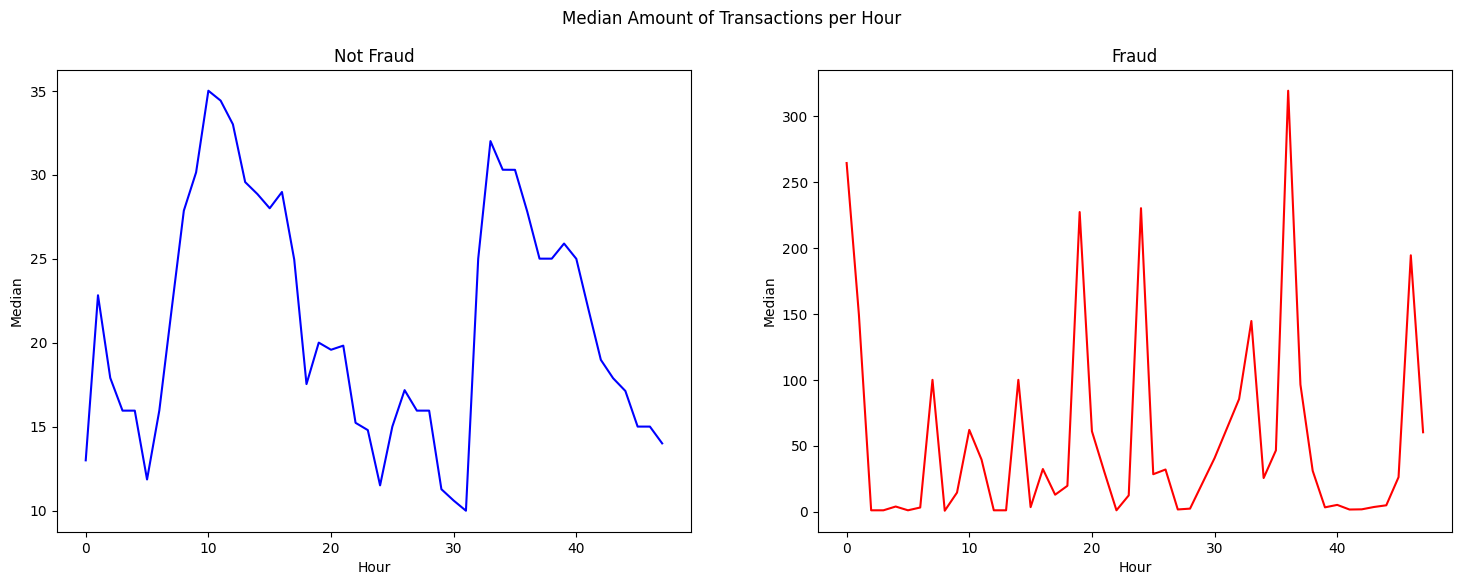

In [48]:
# Median Amount of Transactions over time for both fraud and notfraud transactions
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(18,6))
s = sns.lineplot(ax=ax1,x="Hour",y="Median",data = dft.loc[dft.Class == 0],color='blue')
s = sns.lineplot(ax=ax2,x="Hour",y="Median",data = dft.loc[dft.Class == 1],color="red")
plt.suptitle("Median Amount of Transactions per Hour")
ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

Text(0.5, 1.0, 'Fraud')

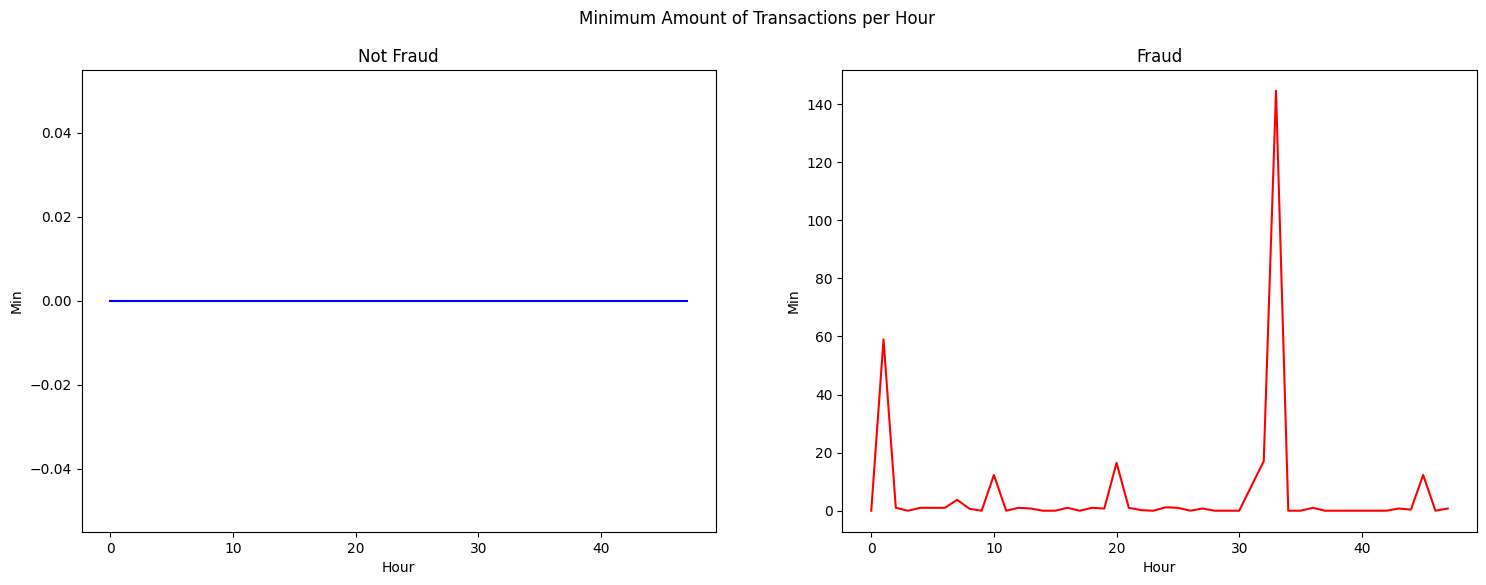

In [52]:
# Minimum Amount of Transactions over time for both fraud and notfraud transactions
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(18,6))
s = sns.lineplot(ax=ax1,x="Hour",y="Min",data = dft.loc[dft.Class == 0],color='blue')
s = sns.lineplot(ax=ax2,x="Hour",y="Min",data = dft.loc[dft.Class == 1],color="red")
plt.suptitle("Minimum Amount of Transactions per Hour")
ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

In [51]:
# Transactions wrt Amount

C:\Users\aryan\AppData\Local\Temp\ipykernel_15092\2171921982.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




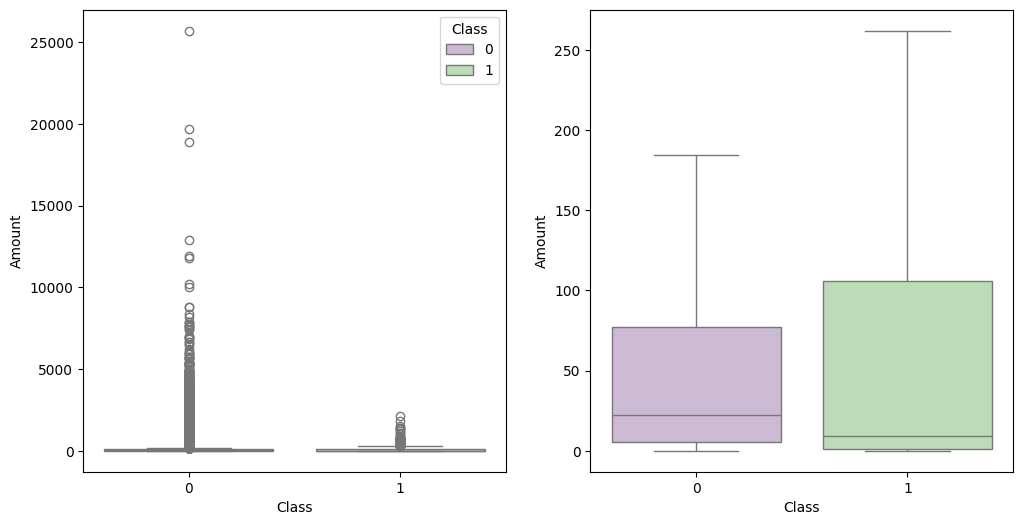

In [56]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))
s1 = sns.boxplot(ax=ax1,x="Class",y="Amount",hue="Class",data = dff,palette="PRGn",showfliers=True)
s1 = sns.boxplot(ax=ax2,x="Class",y="Amount",data = dff,palette="PRGn",showfliers=False)

In [58]:
tmp = dff[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [59]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [60]:
# The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

In [71]:
# Fraud transactions over time
fraud = dff.loc[dff['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
    marker=dict(
        color='rgb(0, 128, 0)',  # Green color
        line=dict(
            color='green',
            width=1),
        opacity=0.5,
    ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True),
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

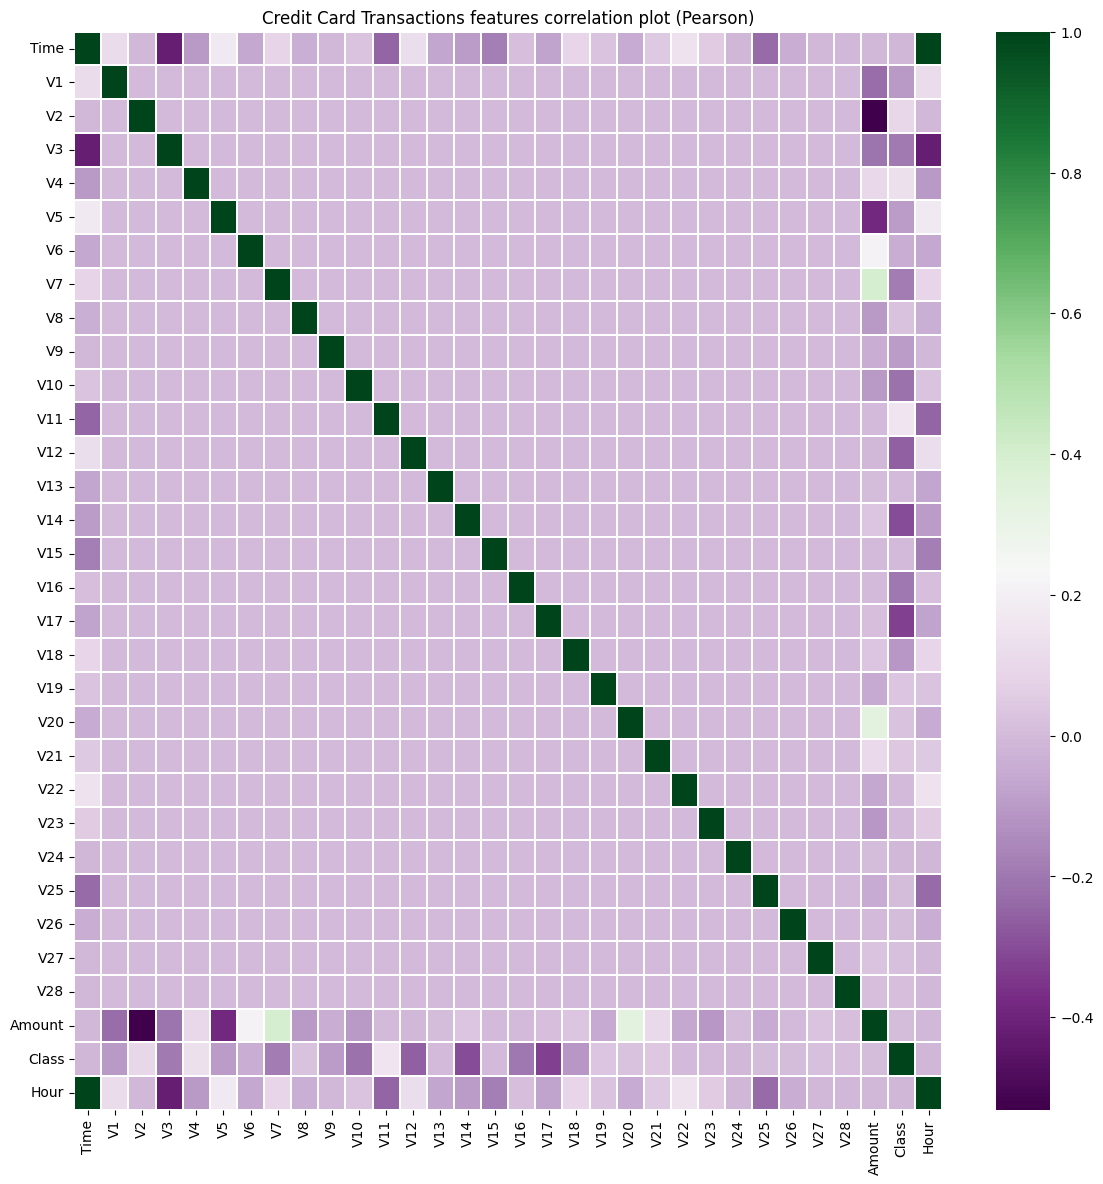

In [82]:

# Set figure size
plt.figure(figsize=(14, 14))

# Set plot title
plt.title('Credit Card Transactions features correlation plot (Pearson)')

# Calculate correlation matrix
corr = dff.corr()
corr
# Create heatmap with labels and colormap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1, cmap="PRGn")

# Display the plot
plt.show()

In [83]:
#As expected, there is no notable correlation between features V1-V28. There are certain correlations between some of these features and Time (inverse correlation with V3) and Amount (direct correlation with V7 and V20, inverse correlation with V1 and V5).

In [84]:
# Below are graphs with correlated and inverse correlated values on the same graph

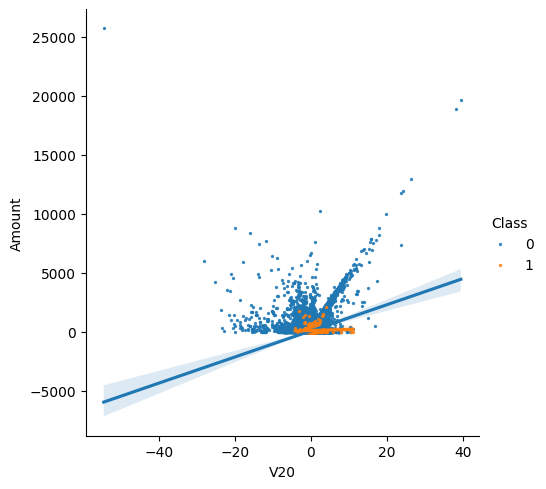

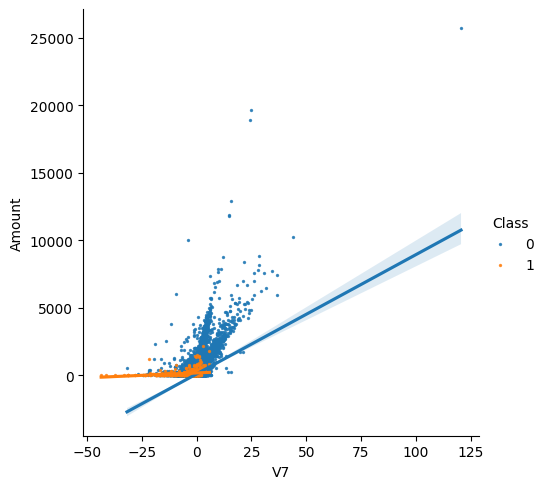

In [88]:
# b/w V20 and V7
s = sns.lmplot(x='V20', y='Amount',data=dff, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=dff, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

In [89]:
# We can confirm that the two couples of features are correlated (the regression lines for Class = 0 have a positive slope, whilst the regression line for Class = 1 have a smaller positive slope).

In [90]:
# the inverse correlated values 

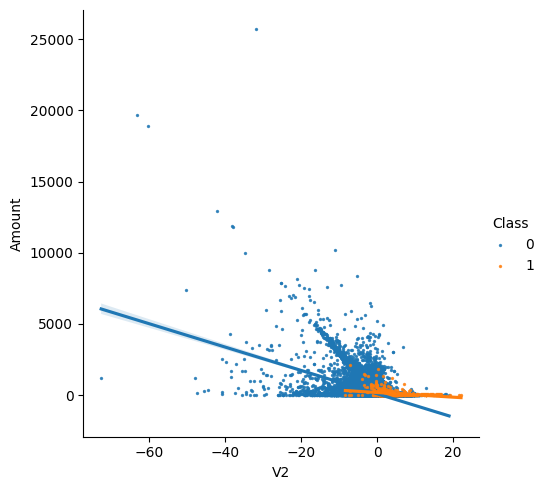

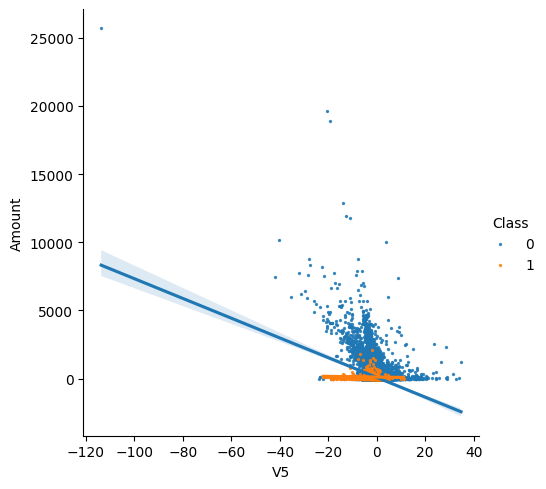

In [93]:
# b/w V2 and V5
s = sns.lmplot(x='V2', y='Amount',data=dff, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=dff, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()


In [94]:
# We can confirm that the two couples of features are inverse correlated (the regression lines for Class = 0 have a negative slope while the regression lines for Class = 1 have a very small negative slope).

C:\Users\aryan\AppData\Local\Temp\ipykernel_15092\2438798271.py:28: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


C:\Users\aryan\AppData\Local\Temp\ipykernel_15092\2438798271.py:29: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


C:\Users\aryan\AppData\Local\Temp\ipykernel_15092\2438798271.py:28: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


C:\Users\aryan\AppData\Local\Temp\ipykernel_15092\2438798271.py:29: UserWarning:



The `bw` paramet

<Figure size 1600x2800 with 0 Axes>

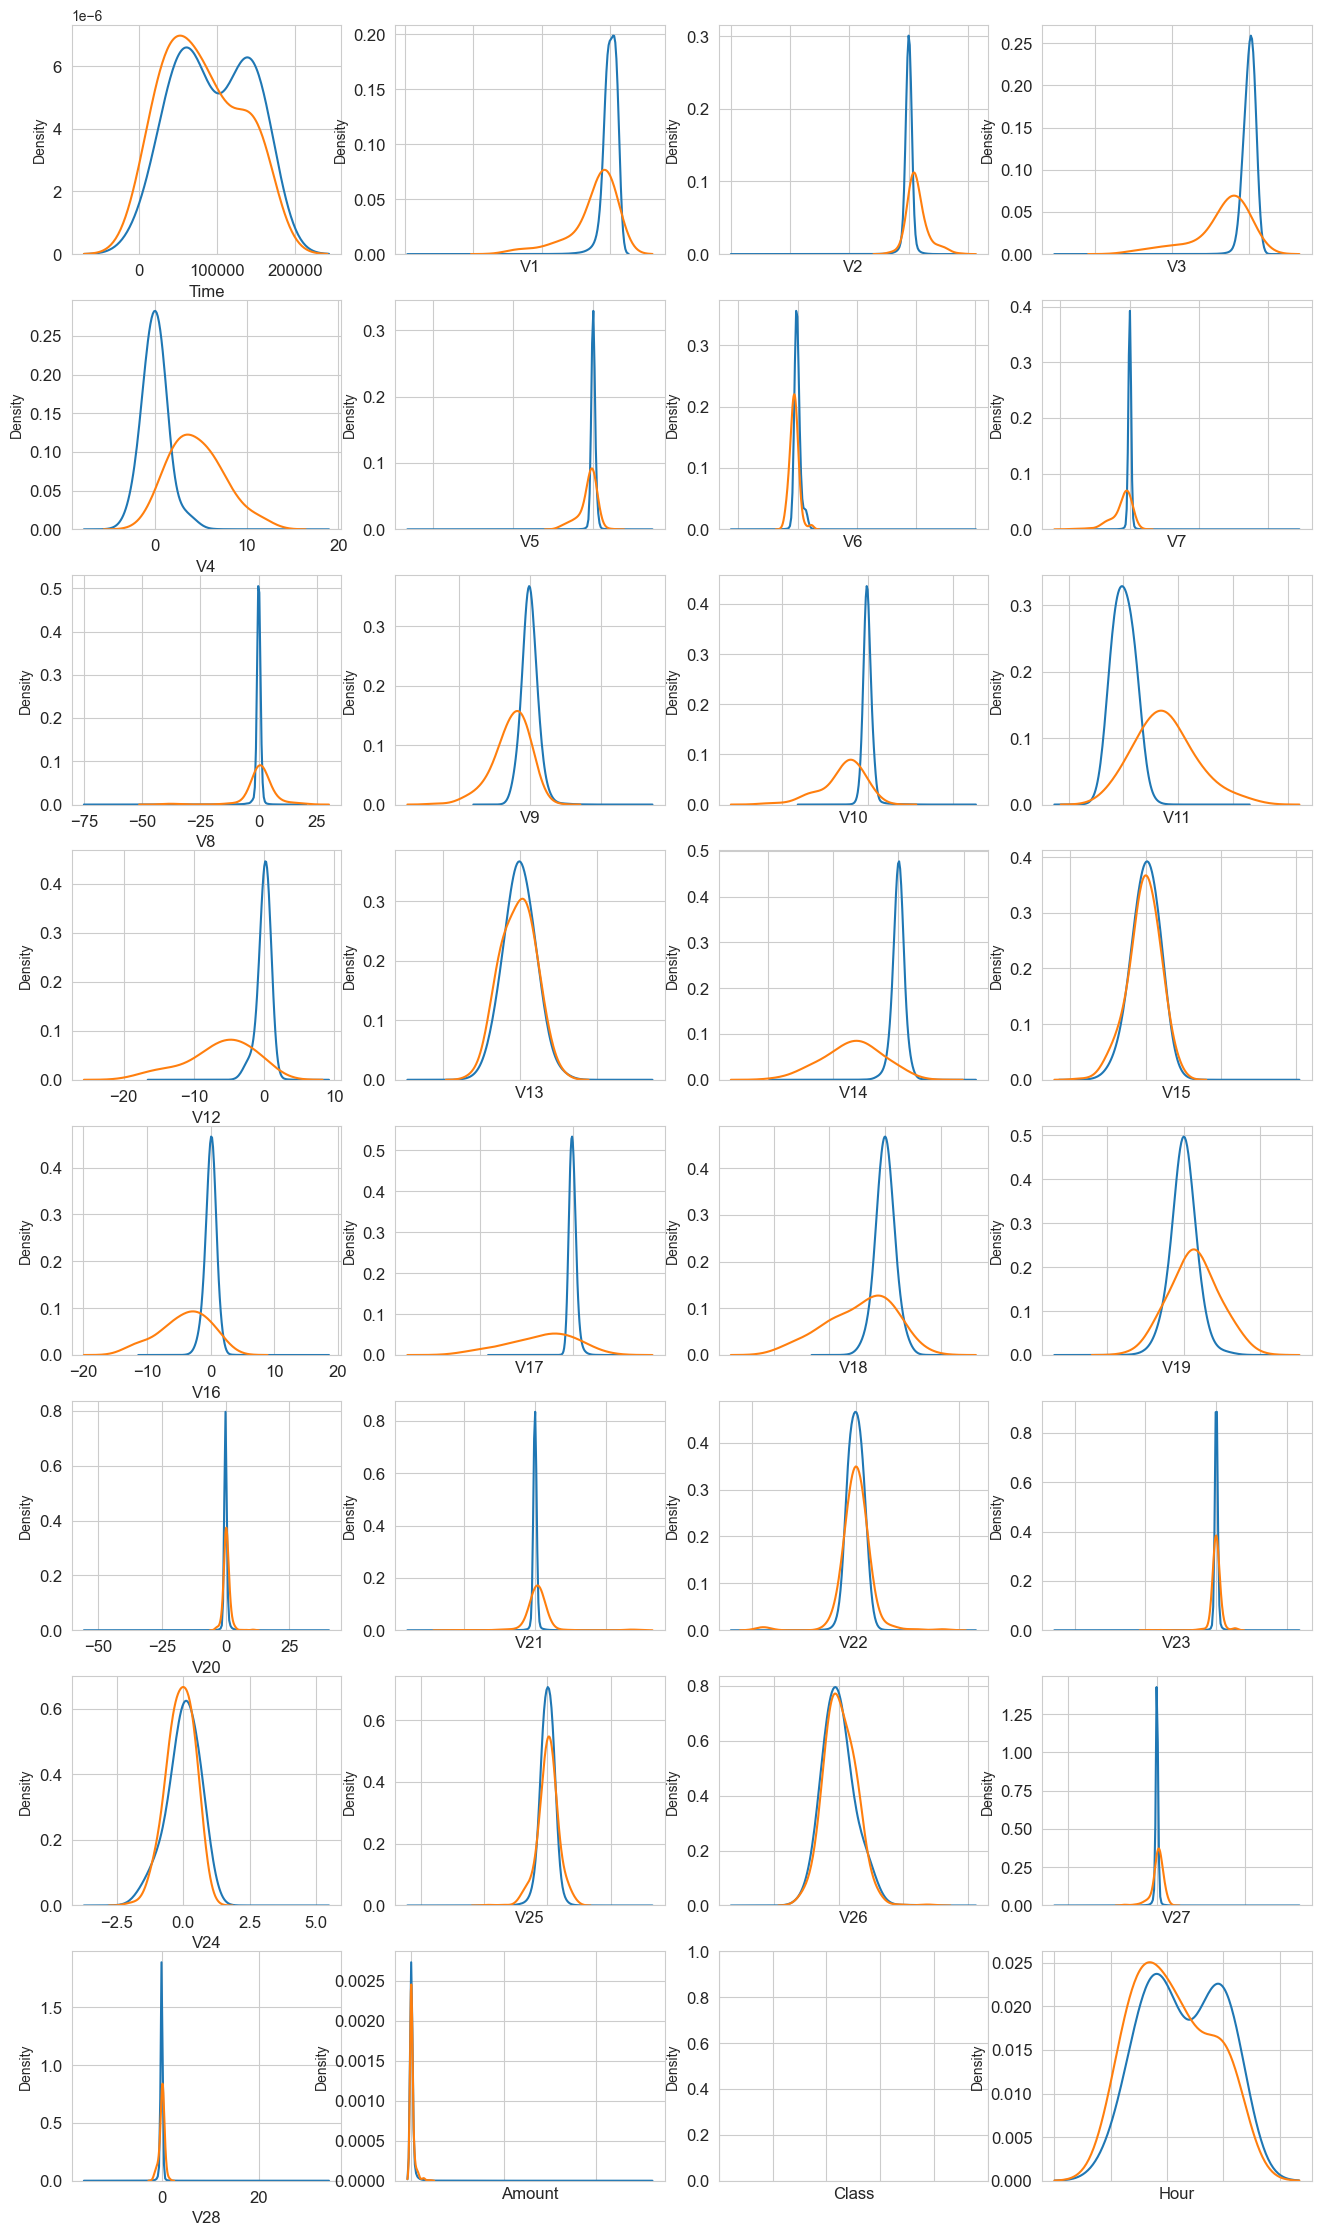

In [97]:
# Get features list from DataFrame
var = dff.columns.values

# Initialize counter
i = 0

# Filter data for each class
t0 = dff.loc[dff['Class'] == 0]  # Class 0 data
t1 = dff.loc[dff['Class'] == 1]  # Class 1 data

# Set plot style
sns.set_style('whitegrid')  # Use white background with gridlines

# Create a figure for subplots
plt.figure(figsize=(16, 28))  # Set figure size

# Create a grid of subplots (8 rows, 4 columns)
fig, ax = plt.subplots(8, 4, figsize=(16, 28))  # Match figure size

# Loop through each feature
for feature in var:
    i += 1  # Increment counter

    # Select subplot based on counter
    ax_current = ax.flat[i - 1]  # Flatten the subplot array for easier indexing

    # Create KDE plots for each class
    sns.kdeplot(t0[feature], bw=0.5, label="Class = 0", ax=ax_current)
    sns.kdeplot(t1[feature], bw=0.5, label="Class = 1", ax=ax_current)

    # Set axis labels for current subplot
    ax_current.set_xlabel(feature, fontsize=12)
    ax_current.tick_params(axis='both', which='major', labelsize=12)

    # Remove extra x-axis labels (only needed on bottom row)
    if i % 4 != 1:  # Check if it's the first subplot in a row
        ax_current.tick_params(labelbottom=False)

# Display the plot
plt.show()

In [101]:
# ----------------------- PREDICTIVE MODELS -----------------------

In [104]:
# Defining predictor features and the target values
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
              'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
              'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
              'Amount']

In [105]:
# Defining Train,Test and Validation sets
train_df, test_df = train_test_split(dff,test_size=TEST_SIZE,random_state=RANDOM_STATE,shuffle=True)
train_df,valid_df = train_test_split(dff,test_size=VALID_SIZE,random_state=RANDOM_STATE,shuffle=True)


In [106]:
# RandomForestClassifier
# We will use as validation criterion GINI, which formula is GINI = 2 * (AUC) - 1, where AUC is the Receiver Operating Characteristic - Area Under Curve (ROC-AUC). 
# Number of estimators is set to 100 and number of parallel jobs is set to 4.

In [108]:
# Initilializing RFC
clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion = RFC_METRIC,
                             n_estimators = NUM_ESTIMATORS,
                             verbose=False)

In [109]:
# Training the RFC model
clf.fit(train_df[predictors],train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [110]:
# Predicting targte values
preds = clf.predict(valid_df[predictors])

C:\Users\aryan\AppData\Local\Temp\ipykernel_15092\710835175.py:15: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



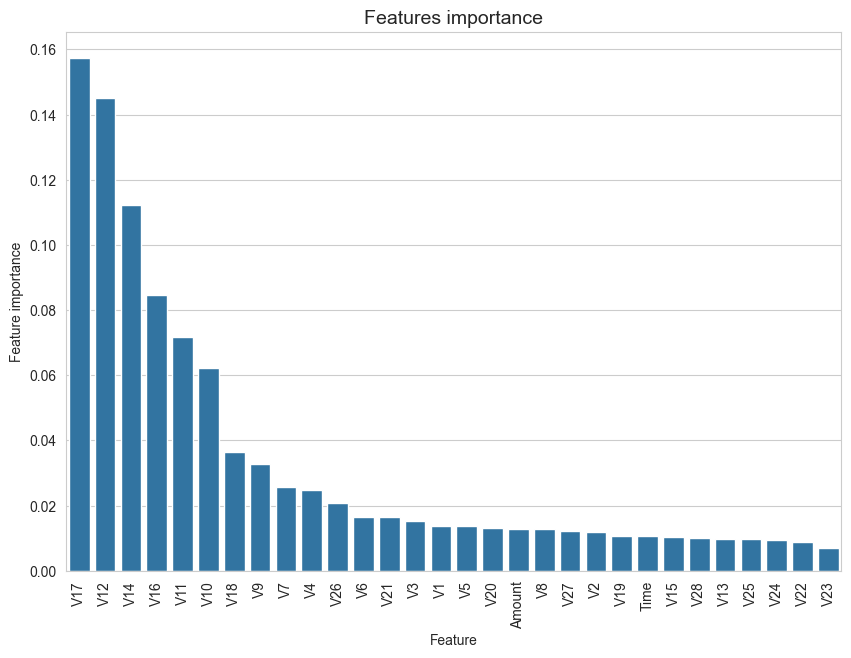

In [113]:

# Create DataFrame with feature names and importance scores
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})

# Sort DataFrame by feature importance in descending order
tmp = tmp.sort_values(by='Feature importance', ascending=False)

# Create figure and set title
plt.figure(figsize=(10, 7))
plt.title('Features importance', fontsize=14)

# Create bar plot
s = sns.barplot(x='Feature', y='Feature importance', data=tmp)

# Rotate x-axis labels for better readability
s.set_xticklabels(s.get_xticklabels(), rotation=90)

# Display the plot
plt.show()

In [114]:
# The most important features are V17, V12, V14, V10, V11, V16

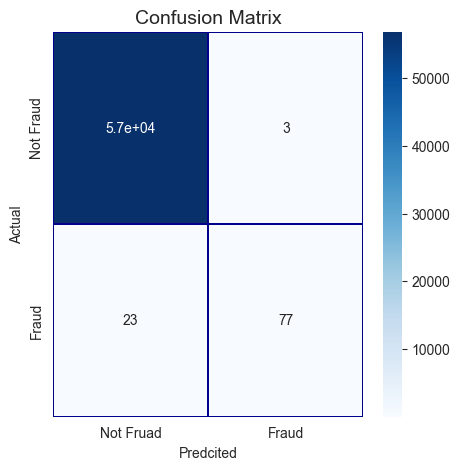

In [117]:
# Making the Confusion Matrix
cm = pd.crosstab(valid_df[target].values,preds,rownames=['Actual'],colnames=['Predcited'])
fig,(ax1) = plt.subplots(ncols=1,figsize=(5,5))
sns.heatmap(cm, annot=True,ax=ax1,xticklabels=['Not Fruad','Fraud'],
            yticklabels=['Not Fraud','Fraud'],
            linewidths=.2,linecolor="Darkblue",cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [118]:
roc_auc_score(valid_df[target].values, preds)

0.8849736203439907

In [119]:
# The ROC-AUC score obtained with RandomForrestClassifier is 0.88.

In [120]:
# Adaptive Boosting Classifier


In [124]:
# Initializing
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [125]:
# Fitting the Model
clf.fit(train_df[predictors],train_df[target].values)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.8, n_estimators=100,
                   random_state=2018)

In [126]:
preds = clf.predict(valid_df[predictors])

C:\Users\aryan\AppData\Local\Temp\ipykernel_15092\499894721.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



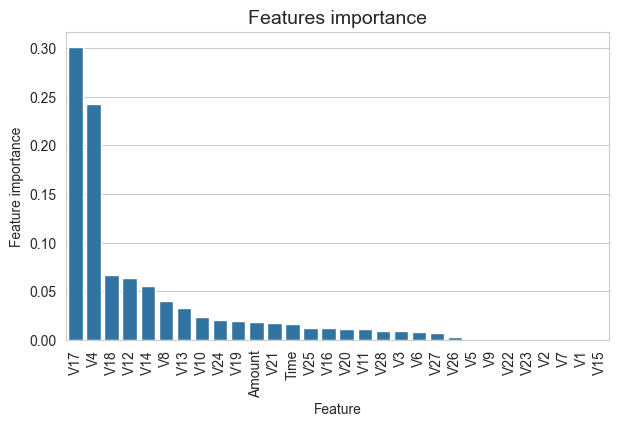

In [127]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


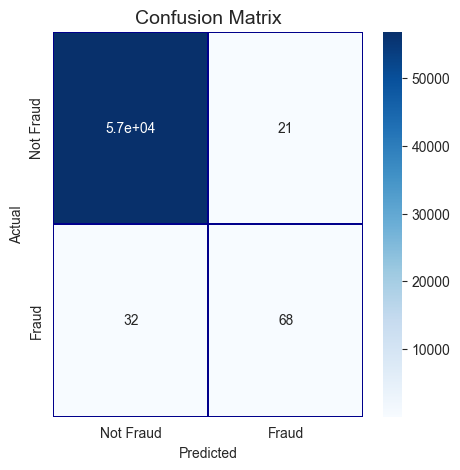

In [128]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [129]:
roc_auc_score(valid_df[target].values, preds)

0.8398153424079351

In [ ]:
# The ROC-AUC score obtained with RandomForrestClassifier is 0.84

In [ ]:
# CatBoostClassifier is a gradient boosting for decision trees algorithm with support for handling categorical data. 

In [130]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [131]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 1.02s	remaining: 8m 28s
50:	total: 36.9s	remaining: 5m 24s
100:	total: 1m 9s	remaining: 4m 33s
150:	total: 1m 39s	remaining: 3m 50s
200:	total: 2m 12s	remaining: 3m 16s
250:	total: 2m 45s	remaining: 2m 43s
300:	total: 3m 17s	remaining: 2m 10s
350:	total: 3m 47s	remaining: 1m 36s
400:	total: 4m 18s	remaining: 1m 3s
450:	total: 4m 48s	remaining: 31.4s
499:	total: 5m 18s	remaining: 0us


In [133]:
preds = clf.predict(valid_df[predictors])

C:\Users\aryan\AppData\Local\Temp\ipykernel_15092\3992975389.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



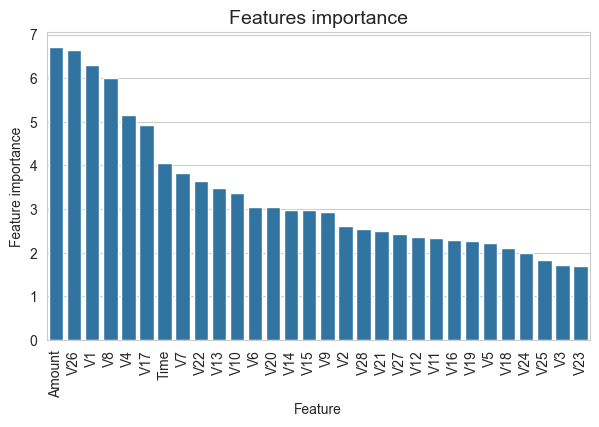

In [134]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

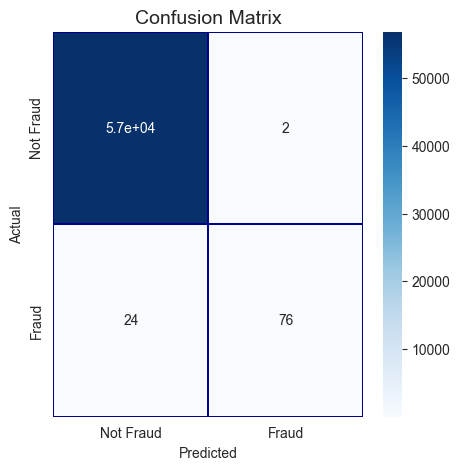

In [135]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [136]:
roc_auc_score(valid_df[target].values, preds)

0.8799824135626606